In [66]:
from astropy_healpix import HEALPix
import astropy_healpix

import h5py
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.nn.conv import *
import torch
from torch.optim import Adam
import torch.nn as nn

from sklearn.metrics import pairwise_distances

import scipy.stats as stats
import pylab

torch.set_default_dtype(torch.float64)

64800 (180, 360)


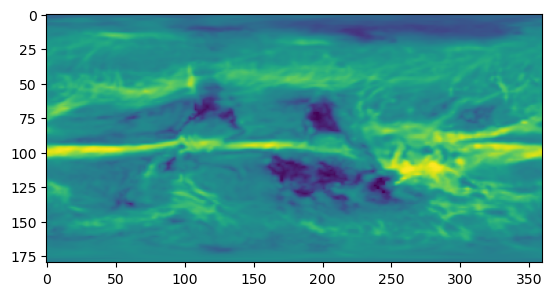

In [2]:
filename = "../data/Ytrain_1_3_small.h5"

h5 = h5py.File(filename, 'r')
Y1 = h5.get('Y1')[:]

print(Y1[0].size, Y1[0].shape)

plt.imshow(Y1[0])

In [3]:
for i in range(10):
    print('Power:', i, 'leads to', 12 * (4 ** i), 'points')

Power: 0 leads to 12 points
Power: 1 leads to 48 points
Power: 2 leads to 192 points
Power: 3 leads to 768 points
Power: 4 leads to 3072 points
Power: 5 leads to 12288 points
Power: 6 leads to 49152 points
Power: 7 leads to 196608 points
Power: 8 leads to 786432 points
Power: 9 leads to 3145728 points


In [4]:
power = 6
index = 12 * (4 ** power)

## convert data

In [5]:
def equiangle_to_healpix(arr, power):
    index = 12 * (4 ** power)
    hp = HEALPix(nside = 2 ** power, order='nested')
    lons, lats = hp.healpix_to_lonlat(range(index))
    
    lons = [int((360 / (2 * np.pi)) * x.radian // 1) for x in lons]
    lats = [int(180 * (0.5 + (x.radian / np.pi)) // 1) for x in lats]

    return arr[lats, lons]

y1_sphere = equiangle_to_healpix(Y1[0], power = 5).reshape(-1, 1)
y1_sphere.shape

(12288, 1)

In [141]:
power = 5

index = 12 * (4 ** power)
hp = HEALPix(nside = 2 ** power, order='nested')
lons, lats = hp.healpix_to_lonlat(range(index))

torch.tensor([x.radian for x in lats]).min()

tensor(-1.5453)

In [147]:
def equiangle_to_healpix_inverse(sphere_data, power):

    equiangle = -100 * torch.ones(180, 360)
    
    index = 12 * (4 ** power)
    hp = HEALPix(nside = 2 ** power, order='nested')
    lons, lats = hp.healpix_to_lonlat(range(index))
    
    lats = torch.tensor([x.radian for x in lats]) # - pi / 2 to pi / 2
    lons = torch.tensor([x.radian for x in lons]) # 0 to 2 pi

    # just need to loop through all points (unless you want a massive matrix lol) and set value to closest point in spherical data
    for i in range(180):
        for j in range(360):
            lat = torch.tensor((torch.pi * (i / 180)) - (torch.pi / 2))
            lon = torch.tensor(2 * torch.pi * (j / 360))

            dister = (torch.sin(lat) * torch.sin(lats)) + (torch.cos(lat) * torch.cos(lats) * torch.cos(lon - lons))
            dists = torch.arccos(dister)

            n = torch.argmin(dists)

            equiangle[i,j] = sphere_data[n]
            
    return equiangle

## get hierarchy

In [6]:
def upsampling_one_level(power):
    """Returns adjacency matrix"""
    x = np.eye(12 * (4 ** power))
    return np.kron(x, np.ones((4, 1))).T

def average_pooling_one_level(power):
    return upsampling_one_level(power).T / 4

upsampling_one_level(1).shape, average_pooling_one_level(1).shape

((48, 192), (192, 48))

## get adjacency

In [7]:
def get_adjacencies(power):
    hp = HEALPix(nside = 2 ** power, order='nested')
    x, y, z = hp.healpix_to_xyz(range(12 * (4 ** power)))
    
    # everyone has 8 neighbors correct??
    X = np.stack((x, y, z)).T
    D = pairwise_distances(X)

    A = D <= np.sort(D, axis = 1)[:,(8)].reshape(-1, 1)
    return np.stack(np.nonzero(A))

In [8]:
A4 = torch.as_tensor(get_adjacencies(5))
A3 = torch.as_tensor(get_adjacencies(4))
A2 = torch.as_tensor(get_adjacencies(3))
A1 = torch.as_tensor(get_adjacencies(2))
A4.shape

torch.Size([2, 110658])

In [9]:
P4_3 = torch.as_tensor(average_pooling_one_level(4))
P3_2 = torch.as_tensor(average_pooling_one_level(3))
P2_1 = torch.as_tensor(average_pooling_one_level(2))

P1_2 = torch.as_tensor(upsampling_one_level(2))
P2_3 = torch.as_tensor(upsampling_one_level(3))
P3_4 = torch.as_tensor(upsampling_one_level(4))
P3_4.shape

torch.Size([3072, 12288])

## define model

In [110]:
class Encoder(nn.Module):
    def __init__(self, hidden_size = 8):
        super().__init__()

        self.enc1a = GCNConv(1, hidden_size)
        self.enc1b = GCNConv(hidden_size, hidden_size)
        self.enc1c = GCNConv(1, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.enc2a = GCNConv(hidden_size, 2 * hidden_size)
        self.enc2b = GCNConv(2 * hidden_size, 2 * hidden_size)
        self.enc2c = GCNConv(hidden_size, 2 * hidden_size)
        self.bn2 = nn.BatchNorm1d(2 * hidden_size)

        self.enc3a = GCNConv(2 * hidden_size, 4 * hidden_size)
        self.enc3b = GCNConv(4 * hidden_size, 4 * hidden_size)
        self.enc3c = GCNConv(2 * hidden_size, 4 * hidden_size)
        self.bn3 = nn.BatchNorm1d(4 * hidden_size)

        self.enc4a = GCNConv(4 * hidden_size, 8 * hidden_size)
        self.enc4b = GCNConv(8 * hidden_size, 8 * hidden_size)
        self.enc4c = GCNConv(4 * hidden_size, 8 * hidden_size)
        self.bn4 = nn.BatchNorm1d(8 * hidden_size)

        self.act = nn.ReLU()

    def forward(self, x): # here we let x just be the data at the points already

        # first block down
        x1 = self.enc1a(x, edge_index = A4)
        x1 = self.act(x1)
        x1 = self.enc1b(x1, edge_index = A4)
        x1 = self.bn1(x1)

        x = self.enc1c(x, edge_index = A4)
        x = self.act(x + x1)

        x = P4_3.T @ x

        # second block down
        x1 = self.enc2a(x, edge_index = A3)
        x1 = self.act(x1)
        x1 = self.enc2b(x1, edge_index = A3)
        x1 = self.bn2(x1)

        x = self.enc2c(x, edge_index = A3)
        x = self.act(x + x1)

        x = P3_2.T @ x

        # third block down
        x1 = self.enc3a(x, edge_index = A2)
        x1 = self.act(x1)
        x1 = self.enc3b(x1, edge_index = A2)
        x1 = self.bn3(x1)

        x = self.enc3c(x, edge_index = A2)
        x = self.act(x + x1)

        x = P2_1.T @ x

        # final block
        x1 = self.enc4a(x, edge_index = A1)
        x1 = self.act(x1)
        x1 = self.enc4b(x1, edge_index = A1)
        x1 = self.bn4(x1)

        x = self.enc4c(x, edge_index = A1)
        
        return x + x1

In [111]:
class Decoder(nn.Module):
    def __init__(self, hidden_size = 8):
        super().__init__()

        self.dec1a = GCNConv(8 * hidden_size, 8 * hidden_size)
        self.dec1b = GCNConv(8 * hidden_size, 4 * hidden_size)
        self.dec1c = GCNConv(8 * hidden_size, 4 * hidden_size)

        self.dec2a = GCNConv(4 * hidden_size, 4 * hidden_size)
        self.dec2b = GCNConv(4 * hidden_size, 2 * hidden_size)
        self.dec2c = GCNConv(4 * hidden_size, 2 * hidden_size)

        self.dec3a = GCNConv(2 * hidden_size, 2 * hidden_size)
        self.dec3b = GCNConv(2 * hidden_size, hidden_size)
        self.dec3c = GCNConv(2 * hidden_size, hidden_size)

        self.dec4a = GCNConv(hidden_size, hidden_size)
        self.dec4b = GCNConv(hidden_size, 1)
        self.dec4c = GCNConv(hidden_size, 1)

        self.act = nn.ReLU()

    def forward(self, z, eps):

        z = torch.cat([z, eps], dim = 1)

        # first block
        z1 = self.dec1a(z, edge_index = A1)
        z1 = self.act(z1)
        z1 = self.dec1b(z1, edge_index = A1)

        z = self.dec1c(z, edge_index = A1)
        z = self.act(z + z1)

        z = P1_2.T @ z

        # second block
        z1 = self.dec2a(z, edge_index = A2)
        z1 = self.act(z1)
        z1 = self.dec2b(z1, edge_index = A2)

        z = self.dec2c(z, edge_index = A1)
        z = self.act(z + z1)

        z = P2_3.T @ z

        # third block
        z1 = self.dec3a(z, edge_index = A3)
        z1 = self.act(z1)
        z1 = self.dec3b(z1, edge_index = A3)

        z = self.dec3c(z, edge_index = A1)
        z = self.act(z + z1)

        z = P3_4.T @ z

        # last block (no activation)
        z1 = self.dec4a(z, edge_index = A4)
        z1 = self.act(z1)
        z1 = self.dec4b(z1, edge_index = A4)

        z = self.dec4c(z, edge_index = A4)
        
        return z + z1

In [112]:
P2_1.shape

torch.Size([768, 192])

In [113]:
class DPAGraph(nn.Module):
    def __init__(self, hidden_size = 8):
        super().__init__()
        self.encoder = Encoder(hidden_size = hidden_size)
        self.decoder = Decoder(hidden_size = hidden_size)

        self.hidden_size = hidden_size

    def forward(self, x, k):
        z = self.encoder(x)

        zinput = z[:,0:k]
        epsinput1 = torch.randn(192, 8 * self.hidden_size)[:,k:(8 * self.hidden_size)] 
        epsinput2 = torch.randn(192, 8 * self.hidden_size)[:,k:(8 * self.hidden_size)]

        x_hat1 = self.decoder(zinput, epsinput1)
        x_hat2 = self.decoder(zinput, epsinput2)

        return x_hat1, x_hat2
        

In [151]:
x = torch.as_tensor(equiangle_to_healpix(Y1[0], power = 5).reshape(-1, 1), dtype = torch.float64)
dpa = DPAGraph()
dpa(x, 60)

(tensor([[-0.2301],
         [-0.2196],
         [-0.1639],
         ...,
         [-1.4936],
         [-1.5912],
         [-1.3612]], grad_fn=<AddBackward0>),
 tensor([[-0.4056],
         [-0.3527],
         [-0.3202],
         ...,
         [-1.6057],
         [-1.6641],
         [-1.4611]], grad_fn=<AddBackward0>))

In [ ]:
model = DPAGraph()
optimizer = Adam(model.parameters(), lr = 0.001)

for epoch in range(400):
    
    optimizer.zero_grad()
    Lk = [0. for _ in range(32, 64 + 1, 8)]
        
    for i, k in enumerate(range(32, 64 + 1, 8)):
        
        #for n in range(50): # this was 100 before

        x1, x2 = model(x, k)
        Lk[i] = Lk[i] + torch.mean((x - x1)**2) + torch.mean((x - x2)**2) - torch.mean((x1 - x2)**2)

        #print('=== Epoch', epoch, '| k =', k,'===')
            
    Lk = torch.stack([l / (2 * (1)) for l in Lk])
    Lk = torch.mean(Lk)

    Lk.backward()
    optimizer.step()
    
    print('=== Epoch', epoch, '| Loss:', Lk.item(), '===')


=== Epoch 0 | Loss: 7.056875835168858 ===
=== Epoch 1 | Loss: 4.262608501954299 ===
=== Epoch 2 | Loss: 3.230269476617127 ===
=== Epoch 3 | Loss: 2.6545191249653763 ===
=== Epoch 4 | Loss: 2.251179045884197 ===
=== Epoch 5 | Loss: 2.072876395236965 ===
=== Epoch 6 | Loss: 1.9107336123800063 ===
=== Epoch 7 | Loss: 1.8150684950305334 ===
=== Epoch 8 | Loss: 1.7376182908656286 ===
=== Epoch 9 | Loss: 1.6835648095147295 ===
=== Epoch 10 | Loss: 1.6383878331241728 ===
=== Epoch 11 | Loss: 1.5899108888680618 ===
=== Epoch 12 | Loss: 1.5496671293247999 ===
=== Epoch 13 | Loss: 1.509080344642706 ===
=== Epoch 14 | Loss: 1.4720954657658325 ===
=== Epoch 15 | Loss: 1.4338942231886473 ===
=== Epoch 16 | Loss: 1.4164122689083718 ===
=== Epoch 17 | Loss: 1.4094477676995063 ===
=== Epoch 18 | Loss: 1.3898435266395492 ===
=== Epoch 19 | Loss: 1.3782623809277181 ===
=== Epoch 20 | Loss: 1.3581366599840123 ===
=== Epoch 21 | Loss: 1.3449709697186103 ===
=== Epoch 22 | Loss: 1.3295325658408583 ===
=== 

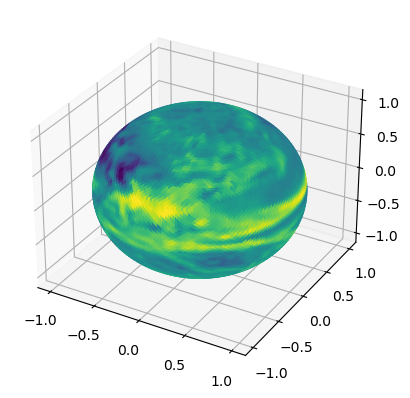

In [126]:
power = 5

hp = HEALPix(nside = 2 ** power, order='nested')
xx, yy, zz = hp.healpix_to_xyz(range(12 * (4 ** power)))

# everyone has 8 neighbors correct??
level4 = np.stack((xx, yy, zz)).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(level4[:,0], level4[:,1], level4[:,2], c = x[:,0])

In [153]:
x1, x2 = dpa(x, 48)

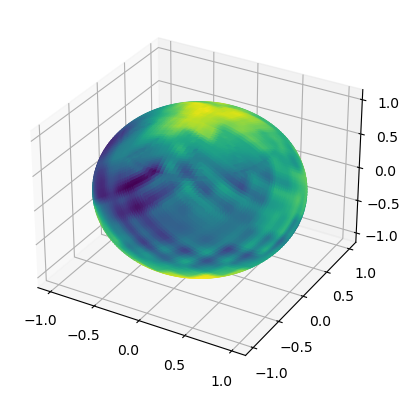

In [154]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(level4[:,0], level4[:,1], level4[:,2], c = x1.detach()[:,0])

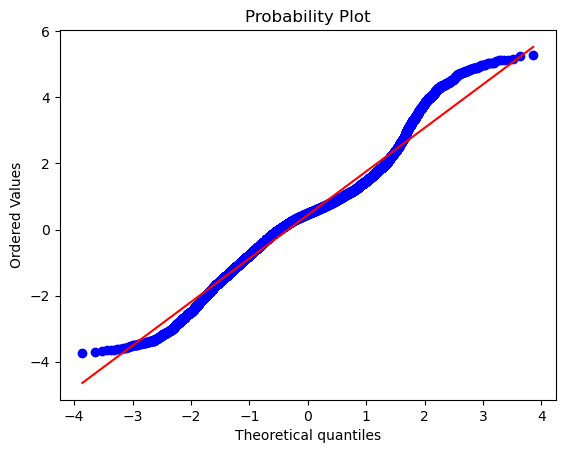

In [129]:
#stats.probplot((x1 - x).detach()[:,0], dist="norm", plot=pylab)
stats.probplot((x2 - x).detach()[:,0], dist="norm", plot=pylab)
pylab.show()

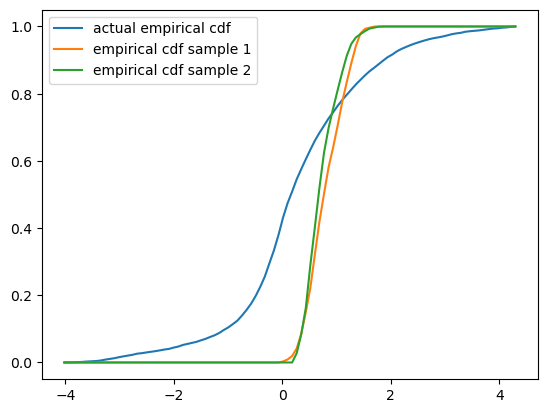

In [130]:
x_values = torch.linspace(x.min(), x.max(), 100)

plt.plot(x_values, [torch.mean(1. * (x < xi)) for xi in x_values], label = 'actual empirical cdf')
plt.plot(x_values, [torch.mean(1. * (x1 < xi)) for xi in x_values], label = 'empirical cdf sample 1')
plt.plot(x_values, [torch.mean(1. * (x2 < xi)) for xi in x_values], label = 'empirical cdf sample 2')
plt.legend()

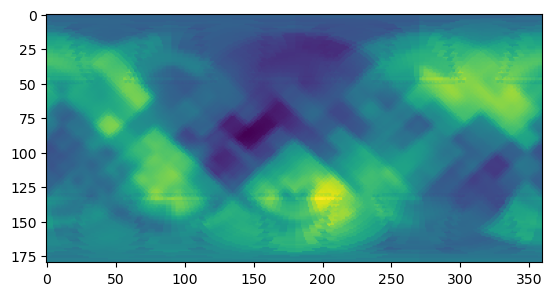

In [149]:
plt.imshow(equiangle_to_healpix_inverse(x1.detach(), power = 5)) # power = 5 takes 22 seconds

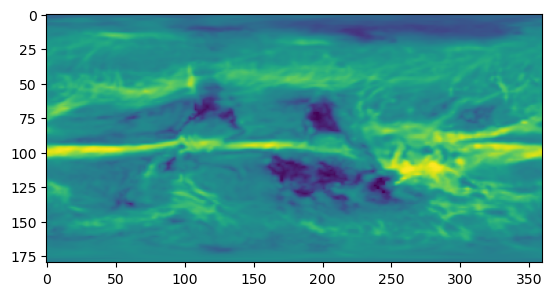

In [150]:
plt.imshow(Y1[0])